In [2]:
# !pip install\
# "git+https://github.com/Sea-Meets-the-Stars/llc4320-native-grid-preprocessing.git@data_loader" \
# --no-deps

%pip install -e ../. --no-deps

# To register a kernel in conda 
# python -m ipykernel install --user --name name --display-name "Python (name)"
# then select that kernel in the notebook

Obtaining file:///home/jovyan/git/DBOF_Representation_Learning
  Installing build dependencies ... one
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... one
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for fronts_representation_learning (pyproject.toml) ... done
  Created wheel for fronts_representation_learning: filename=fronts_representation_learning-0.0.dev0-0.editable-py3-none-any.whl size=1846 sha256=b823ecf9bb9bd0831da8083eb25deaf34ae0d5b59ecdd898092c030645b32b53
  Stored in directory: /tmp/pip-ephem-wheel-cache-0c8g8oni/wheels/5e/0c/2c/2cff4c449c6b3e618a7f923c6f07ac056ed1745e2f311e1d31
Successfully built fronts_representation_learning
  Attempting uninstall: fronts_representation_learning
    Found existing installation: fronts_representation_learning 0.0.dev0
    Uninstalling fronts_representation_learning-0.0.dev0:
      Successfully uninstalled fronts_representation_learning-0.0.dev0

[noti

In [2]:
!cat /sys/fs/cgroup/memory.max 2>/dev/null || cat /sys/fs/cgroup/memory/memory.limit_in_bytes

272730423296


In [3]:
import dbof.dataset_creation.zarr_dataset as zarr_dataset
import dbof.io.filesystems as filesystems

In [4]:
import dataloader.cutout_torch_dataloader as dbof_dataloader

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from dask.distributed import Client
import torch
from torch.utils.data import Dataset, DataLoader

In [6]:
# follow link for a progress bar in following steps
client = Client()
client
client.cluster.scale(4) # less workers and more memory
port = client.scheduler_info()["services"]["dashboard"]
# For nrp link is :
#https://jupyterhub-west.nrp-nautilus.io/hub/user-redirect/proxy/{port}/status
print(f"url : https://jupyterhub-west.nrp-nautilus.io/hub/user-redirect/proxy/{port}/status")

/home/jovyan/conda_envs/dbof_training/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45297 instead
  warnings.warn(


url : https://jupyterhub-west.nrp-nautilus.io/hub/user-redirect/proxy/45297/status


2026-02-19 01:33:32,089 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='jupyterhub-west.nrp-nautilus.io', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/jovyan/conda_envs/dbof_training/lib/python3.12/site-packages/tornado/websocket.py", line 965, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/dbof_training/lib/python3.12/site-packages/tornado/web.py", line 3388, in wrapper
    return method(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/dbof_training/lib/python3.12/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired. Configure the app with a larger value for --session-token-expiration if nece

In [7]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45297/status,
Dashboard: http://127.0.0.1:45297/status,Workers: 4
Total threads: 16,Total memory: 127.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34599,Workers: 0
Dashboard: http://127.0.0.1:45297/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B
Comm: tcp://127.0.0.1:35275,Total threads: 4
Dashboard: http://127.0.0.1:41427/status,Memory: 31.75 GiB
Nanny: tcp://127.0.0.1:35869,


In [10]:
bucket = "dbof" #data_cfg["bucket"]
folder = "native_grid_dbof_training_data"
s3_endpoint = "https://s3-west.nrp-nautilus.io"
feature_channels = ['Eta', 'Salt', 'Theta', 'U', 'V', 'W', 'relative_vorticity', 'log_gradb']
run_id = "big_run_00"

fs, fs_synch = filesystems.create_s3_filesystems(s3_endpoint)

reader = zarr_dataset.ZarrDatasetReader(
    bucket=bucket,
    folder=folder,
    run_id=run_id,
    dataset_name="dataset_creation.zarr",
    fs=fs
)

# Dataloader


In [11]:
# Make sure you have a ton of ram ~ 200gb if you want to load the whole thing in a reasonable time. 
loader = dbof_dataloader.make_dbof_cutout_dataloader(reader, client, batch_size=64, transform=None)

Loading Images into memory...


2026-02-19 01:38:35,978 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 25.41 GiB -- Worker memory limit: 31.75 GiB
2026-02-19 01:38:36,649 - distributed.worker.memory - WARNING - Worker is at 69% memory usage. Resuming worker. Process memory: 21.99 GiB -- Worker memory limit: 31.75 GiB


Loading ids into memory...


/home/jovyan/conda_envs/dbof_training/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


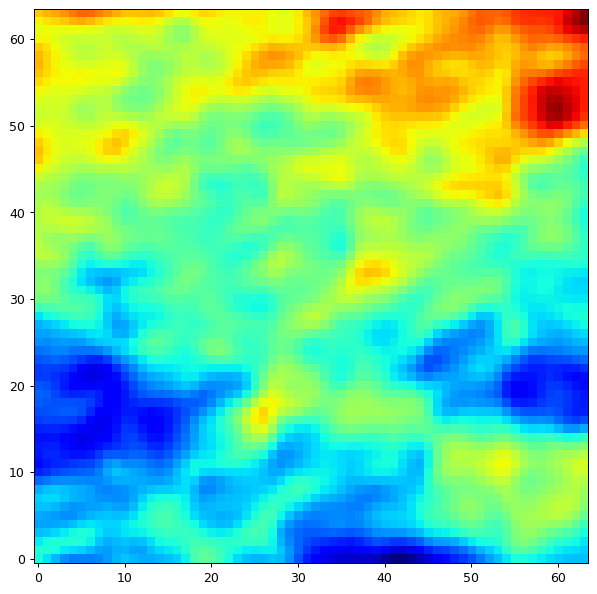

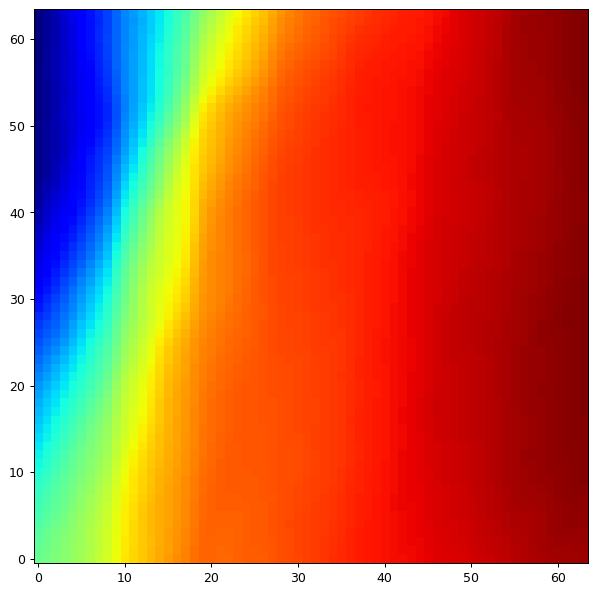

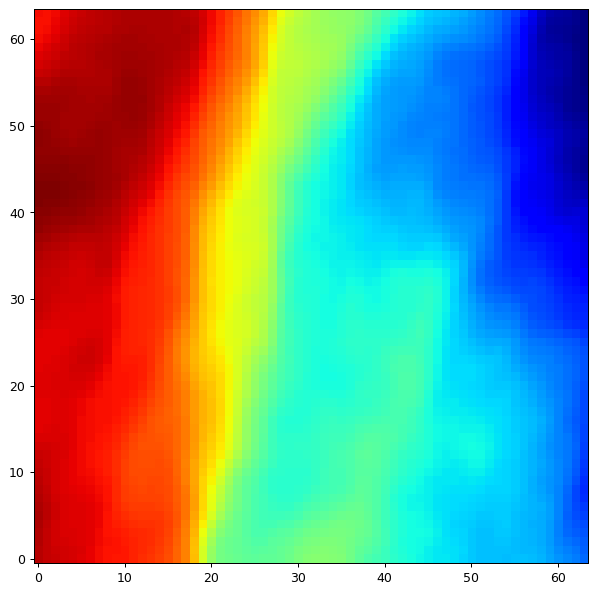

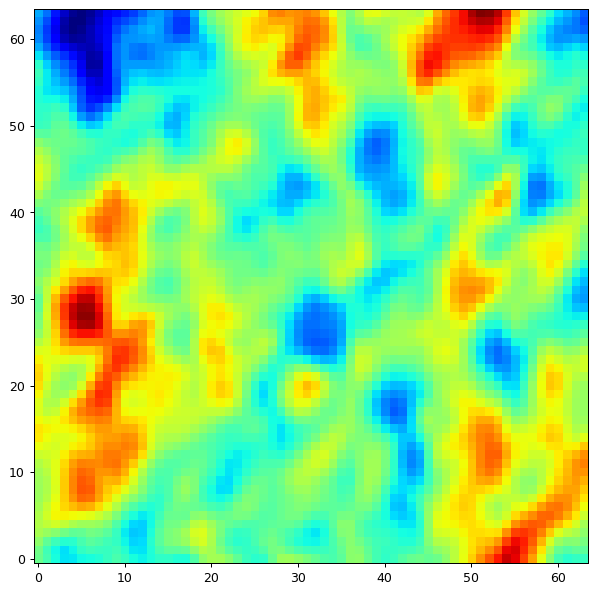

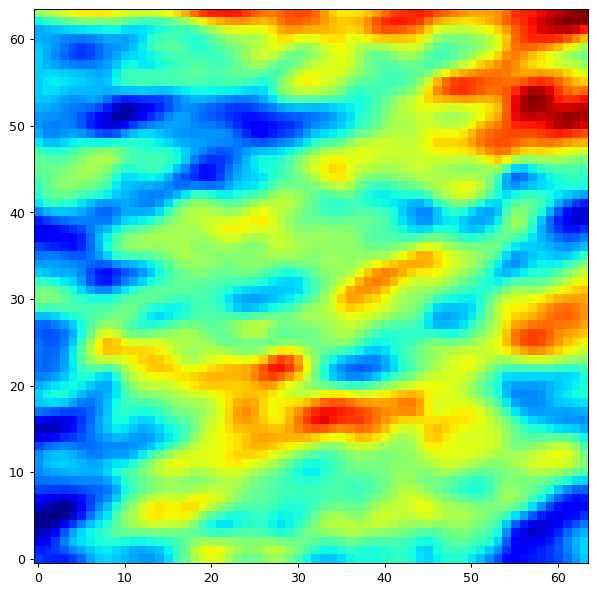

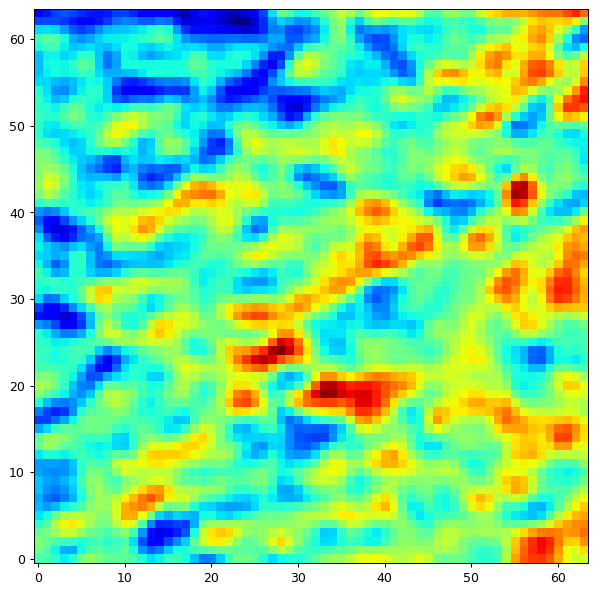

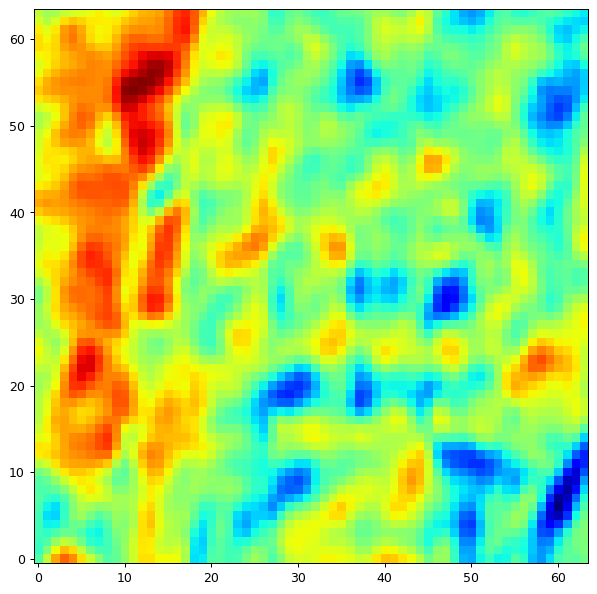

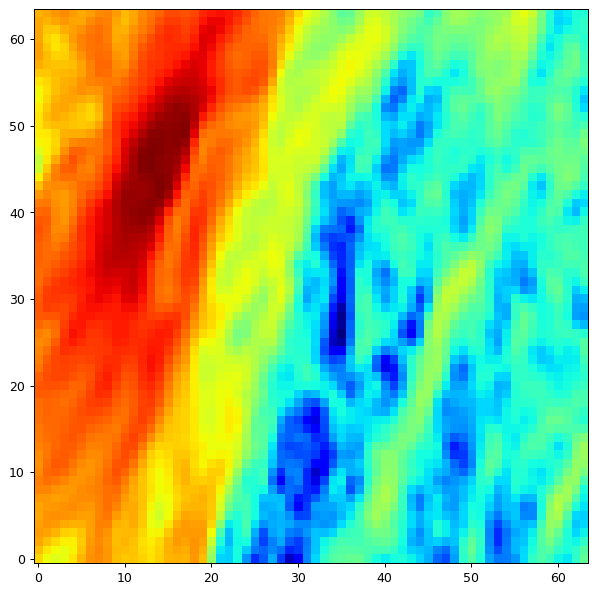

In [12]:
for x in loader:
    for i in x[0]:
        plt.figure(figsize=(8,8), dpi= 90)
        plt.imshow(i,origin='lower',cmap='jet')
    break

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

In [ ]:
# A dataset run generates many metadata files.
files = fs_synch.glob(
    f"{bucket}/{folder}/{run_id}/metadata/*.parquet"
)

meta_df = pd.read_parquet(files, filesystem=fs_synch)

In [ ]:
meta_df

In [ ]:
lats = meta_df["center_lat"].values
lons = meta_df["center_lon"].values


cmap = plt.get_cmap("tab10")

fig = plt.figure(figsize=(11, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()
ax.coastlines()

sc = ax.scatter(
    lons,
    lats,
    cmap=cmap,
    s=8,
    alpha=0.05,
    transform=ccrs.PlateCarree()
)

plt.title("Sampled Points By Year \nBias = 1.3")
plt.show()

In [ ]:
import cmocean


def plot_image_features(imgs, ids):
    """
    imgs: (N, C, H, W)
    """

    N, C, H, W = imgs.shape

    fig = plt.figure(figsize=(2.5*(C+1), 2.5*N))
    gs = fig.add_gridspec(N, C + 1, wspace=0.5, hspace=0.15)

    for i in range(N):
        row_data = imgs[i]

        for c in range(C):
            ax = fig.add_subplot(gs[i, c])

            # vmin = np.nanmin(row_data[c])
            # vmax = np.nanmax(row_data[c])


            if c == 0:
                cmap = cmocean.cm.gray
            elif c == 1 :
                cmap = cmocean.cm.haline
            elif c == 2 :
                cmap = cmocean.cm.thermal
            elif c == 6 :
                cmap = cmocean.cm.diff
            else :
                cmap = cmocean.cm.speed



            im = ax.imshow(row_data[c], cmap=cmap) #, vmin=vmin, vmax=vmax)
            ax.set_xticks([])
            ax.set_yticks([])

            if i == 0:
                ax.set_title(f"{feature_channels[c]}", fontsize=10)

            fig.colorbar(
                im,
                ax=ax,
                fraction=0.046,
                pad=0.01 #format="%4.2"
            )

    plt.show()

rand_indices = np.random.randint(0, reader.num_images, size=4)
imgs, ids = reader.get_images(rand_indices)

plot_image_features(imgs, ids)

# Metadata for each sample
subset_df = (
    meta_df
    .set_index("dataset_index")
    .loc[ids]
    .reset_index()
)
subset_df

In [ ]:
import cmocean


def plot_image_features(imgs, ids):
    """
    imgs: (N, C, H, W)
    """

    N, C, H, W = imgs.shape

    fig = plt.figure(figsize=(2.5*(C+1), 2.5*N))
    gs = fig.add_gridspec(N, C + 1, wspace=0.5, hspace=0.15)

    for i in range(N):
        row_data = imgs[i]

        for c in range(C):
            ax = fig.add_subplot(gs[i, c])

            # vmin = np.nanmin(row_data[c])
            # vmax = np.nanmax(row_data[c])


            if c == 0:
                cmap = cmocean.cm.gray
            elif c == 1 :
                cmap = cmocean.cm.haline
            elif c == 2 :
                cmap = cmocean.cm.thermal
            elif c == 6 :
                cmap = cmocean.cm.diff
            else :
                cmap = cmocean.cm.speed



            im = ax.imshow(row_data[c], cmap=cmap) #, vmin=vmin, vmax=vmax)
            ax.set_xticks([])
            ax.set_yticks([])

            if i == 0:
                ax.set_title(f"{feature_channels[c]}", fontsize=10)

            fig.colorbar(
                im,
                ax=ax,
                fraction=0.046,
                pad=0.01 #format="%4.2"
            )

    plt.show()

rand_indices = np.random.randint(0, reader.num_images, size=4)
imgs, ids = reader.get_images(rand_indices)

plot_image_features(imgs, ids)

# Metadata for each sample
subset_df = (
    meta_df
    .set_index("dataset_index")
    .loc[ids]
    .reset_index()
)
subset_df